# <center> Normalization-Equivariant Neural Networks with Application to Image Denoising 

## <center> Sébastien Herbreteau, Emmanuel Moebel and Charles Kervrann

### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append("./models")
sys.path.append("./utilities")
from fdncnn import *
from drunet import *
from utilities import *

### Load trained weights for non-blind models (FDnCNN)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Ordinary
m_fdncnn_O = FDnCNN(blind=False, bias=True).to(device)
m_fdncnn_O.load_state_dict(torch.load("./saved_models_fdncnn/ordinary/noisemap.pth", map_location=device), strict=True)

# Scale-equivariant
m_fdncnn_SE = FDnCNN(blind=False, bias=False).to(device)
m_fdncnn_SE.load_state_dict(torch.load("./saved_models_fdncnn/scale_equiv/noisemap.pth", map_location=device), strict=True)

# Normalization-equivariant
m_fdncnn_NE = FDnCNN_NE(blind=False).to(device)
m_fdncnn_NE.load_state_dict(torch.load("./saved_models_fdncnn/norm_equiv/noisemap.pth", map_location=device), strict=True)

<All keys matched successfully>

### Load trained weights for blind models dedicated to a single noise level (FDnCNN)

In [3]:
noise_level = 25
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Ordinary
m_fdncnn_O25 = FDnCNN(blind=True, bias=True).to(device)
m_fdncnn_O25.load_state_dict(torch.load("./saved_models_fdncnn/ordinary/sigma"+str(noise_level)+"_blind.pth", map_location=device), strict=True)

# Scale-equivariant
m_fdncnn_SE25 = FDnCNN(blind=True, bias=False).to(device)
m_fdncnn_SE25.load_state_dict(torch.load("./saved_models_fdncnn/scale_equiv/sigma"+str(noise_level)+"_blind.pth", map_location=device), strict=True)

# Normalization-equivariant
m_fdncnn_NE25 = FDnCNN_NE(blind=True).to(device)
m_fdncnn_NE25.load_state_dict(torch.load("./saved_models_fdncnn/norm_equiv/sigma"+str(noise_level)+"_blind.pth", map_location=device), strict=True)

<All keys matched successfully>

# 1. The 3 variants share similar visual qualities and performance

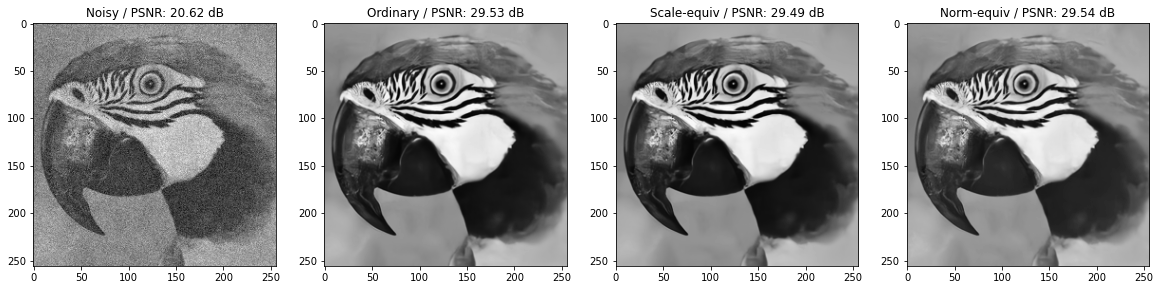

In [4]:
torch.manual_seed(12345678)
img = load_img("./testset_set12/07.png")
sigma = 25/255
img_noisy = noise_img(img, sigma)

with torch.no_grad():
    den_O = m_fdncnn_O(img_noisy, sigma)
    den_SE = m_fdncnn_SE(img_noisy, sigma)
    den_NE = m_fdncnn_NE(img_noisy, sigma)
titles = []
titles.append("Noisy / PSNR: " +  str(round(psnr(img, img_noisy), 2)) + " dB")
titles.append("Ordinary / PSNR: " +  str(round(psnr(img, den_O), 2)) + " dB")
titles.append("Scale-equiv / PSNR: " +  str(round(psnr(img, den_SE), 2)) + " dB")
titles.append("Norm-equiv / PSNR: " +  str(round(psnr(img, den_NE), 2)) + " dB")
show_img([img_noisy, den_O, den_SE, den_NE], titles=titles)

## Checking equivariances

A function $f : \mathbb{R}^n \mapsto \mathbb{R}^m$ is said to be:

-$\textit{scale-equivariant}$ if $\: \forall x \in \mathbb{R}^n, \forall \lambda \in \mathbb{R}^+_\ast, \: f(\lambda x) = \lambda f(x)\,,$


-$\textit{shift-equivariant}$ if  $\: \forall x \in \mathbb{R}^n, \forall \mu \in \mathbb{R}, \:  f(x + \mu) = f(x) + \mu\,,$
 
 
-$\textit{normalization-equivariant}$ if it is both $\textit{scale-equivariant}$ and $\textit{shift-equivariant}$: 
$$
\forall x \in \mathbb{R}^n, \forall \lambda \in \mathbb{R}^+_\ast, \forall \mu \in \mathbb{R}, \: f(\lambda x + \mu) = \lambda f(x) + \mu\,, 
$$
where addition with the scalar shift $\mu$ is applied element-wise.

If $\sigma$ is passed as an additional parameter, $f_\theta$ is $\textit{normalization-equivariant}$ if: $$\forall (x, \sigma) \in \mathbb{R}^n \times \mathbb{R}^+_\ast,  \forall \lambda \in \mathbb{R}^+_\ast, \forall \mu \in \mathbb{R}, \: f(\lambda x + \mu, \lambda \sigma) = \lambda f( x ,\sigma) + \mu \,.$$

In [5]:
def is_scale_equiv(model, x, lam, sigma=None, tol=1e-3):
    with torch.no_grad():
        if sigma is not None:
            norm = torch.norm(model(lam*x, lam*sigma) - lam*model(x, sigma), p=float('inf'))
        else: 
            norm = torch.norm(model(lam*x) - lam*model(x), p=float('inf'))
    return bool(norm < tol)
    
def is_shift_equiv(model, x, mu, sigma=None, tol=1e-3):
    with torch.no_grad():
        if sigma is not None:
            norm = torch.norm(model(x + mu, sigma) - (model(x, sigma) + mu), p=float('inf'))
        else: 
            norm = torch.norm(model(x + mu) - (model(x) + mu), p=float('inf'))
    return bool(norm < tol)

In [6]:
lam, mu = 40, 10 

# Check scale-equivariance
print("Scale-equivariant: ", end=" ")
print("O:", is_scale_equiv(m_fdncnn_O, img_noisy, lam, sigma=sigma), end=", ")
print("SE:", is_scale_equiv(m_fdncnn_SE, img_noisy, lam, sigma=sigma), end=", ")
print("NE:", is_scale_equiv(m_fdncnn_NE, img_noisy, lam, sigma=sigma), end=".")

print()

# Check shift-equivariance
print("Shift-equivariant: ", end=" ")
print("O:", is_shift_equiv(m_fdncnn_O, img_noisy, mu, sigma=sigma), end=", ")
print("SE:", is_shift_equiv(m_fdncnn_SE, img_noisy, mu, sigma=sigma), end=", ")
print("NE:", is_shift_equiv(m_fdncnn_NE, img_noisy, mu, sigma=sigma), end=".")

Scale-equivariant:  O: False, SE: True, NE: True.
Shift-equivariant:  O: False, SE: False, NE: True.

# 2. Increased robustness across noise levels

Let $x \in \mathbb{R}^n$ an image patch and $\varepsilon \sim \mathcal{N}(0, \sigma^2 I_n)$. Assuming that $f_\theta$ is normalization-equivariant: $$\forall \lambda \in \mathbb{R}^+_\ast, \forall \mu \in \mathbb{R}, \: f_\theta(x+\lambda \varepsilon) = \lambda    f_\theta((x - \mu)/\lambda  +\varepsilon) + \mu \,.$$

Thus, normalization-equivariance simply brings the problem back to the denoising of an implicitly renormalized image patch with fixed noise level $\sigma$. If there exists $(\lambda, \mu) \in \mathbb{R}^2$ such that $(x - \mu)/\lambda$ is a representative image patch of the training set on which $f_\theta$ was trained, then the denoising will be correct. It is possible to get similar denoising results with ordinary or scale-equivariant models but the renormalization, which is explicit this time, must be known (scale or shift tuning).

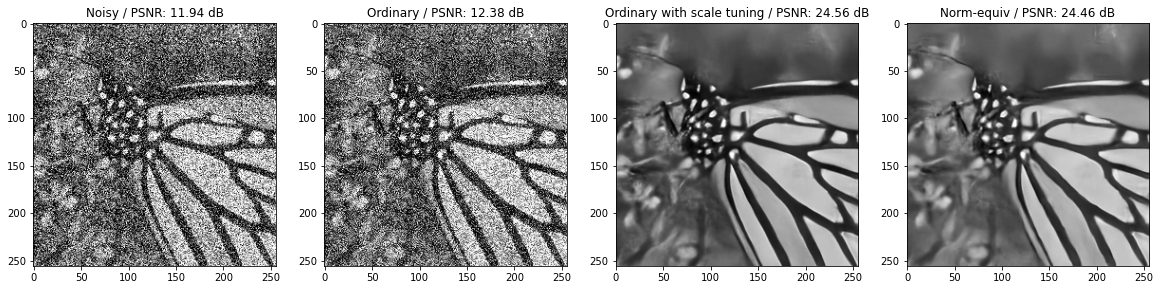

In [7]:
torch.manual_seed(12345678)
img = load_img("./testset_set12/05.png")
sigma = 75/255
img_noisy = noise_img(img, sigma)

with torch.no_grad():
    den_O = m_fdncnn_O25(img_noisy)
    den_O_tuning = 3*m_fdncnn_O25(img_noisy/3)
    den_NE = m_fdncnn_NE25(img_noisy)
titles = []
titles.append("Noisy / PSNR: " +  str(round(psnr(img, img_noisy), 2)) + " dB")
titles.append("Ordinary / PSNR: " +  str(round(psnr(img, den_O), 2)) + " dB")
titles.append("Ordinary with scale tuning / PSNR: " +  str(round(psnr(img, den_O_tuning), 2)) + " dB")
titles.append("Norm-equiv / PSNR: " +  str(round(psnr(img, den_NE), 2)) + " dB")
show_img([img_noisy.clip(0, 1), den_O.clip(0, 1), den_O_tuning.clip(0, 1), den_NE.clip(0, 1)], titles=titles)

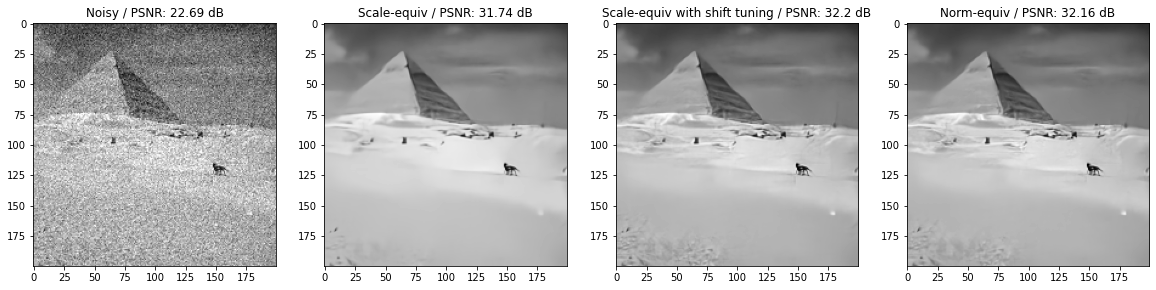

In [8]:
img = load_img("./testset_bsd68/260058.jpg")[:, :, 50:250, -200:]
sigma = 18.75/255
img_noisy = noise_img(img, sigma)

with torch.no_grad():
    den_SE = m_fdncnn_SE25(img_noisy)
    den_SE_tuning = m_fdncnn_SE25(img_noisy - 0.3) + 0.3
    den_NE = m_fdncnn_NE25(img_noisy)
titles = []
titles.append("Noisy / PSNR: " +  str(round(psnr(img, img_noisy), 2)) + " dB")
titles.append("Scale-equiv / PSNR: " +  str(round(psnr(img, den_SE), 2)) + " dB")
titles.append("Scale-equiv with shift tuning / PSNR: " +  str(round(psnr(img, den_SE_tuning), 2)) + " dB")
titles.append("Norm-equiv / PSNR: " +  str(round(psnr(img, den_NE), 2)) + " dB")
show_img([img_noisy.clip(0, 1), den_SE.clip(0, 1), den_SE_tuning.clip(0, 1), den_NE.clip(0, 1)], titles=titles)

# 3. Displaying adaptive filters

Adaptive filters are displayed by computing the gradient of the denoised pixel value with regard to the input.

Sigma: 25


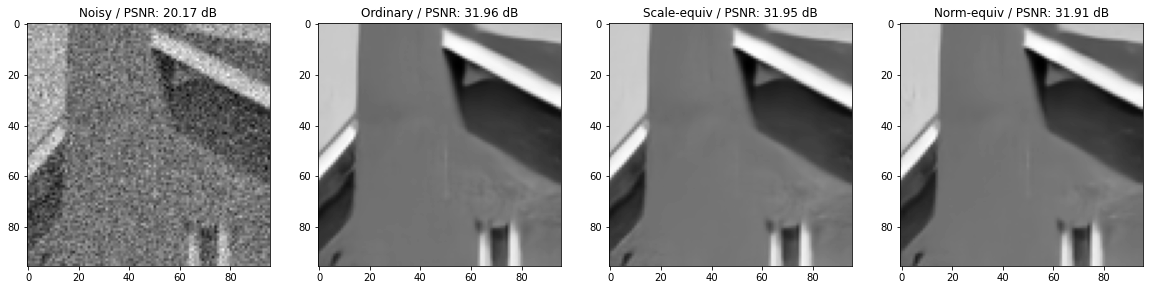

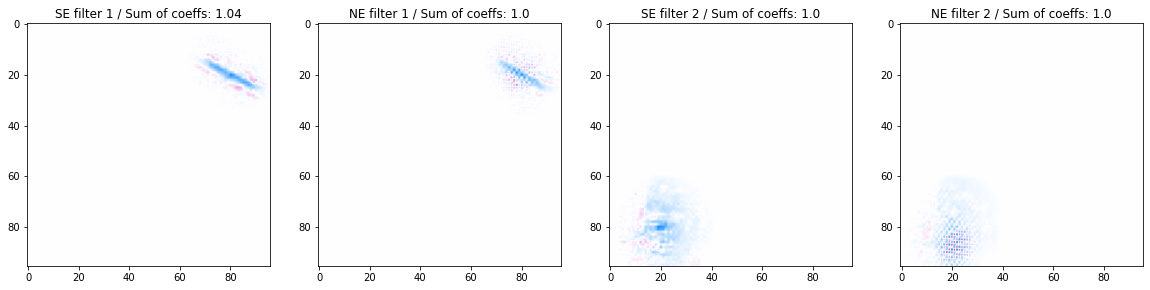

Sigma: 5


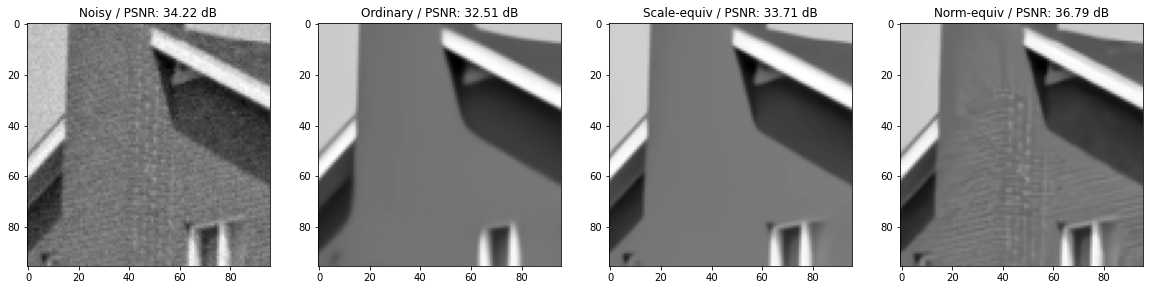

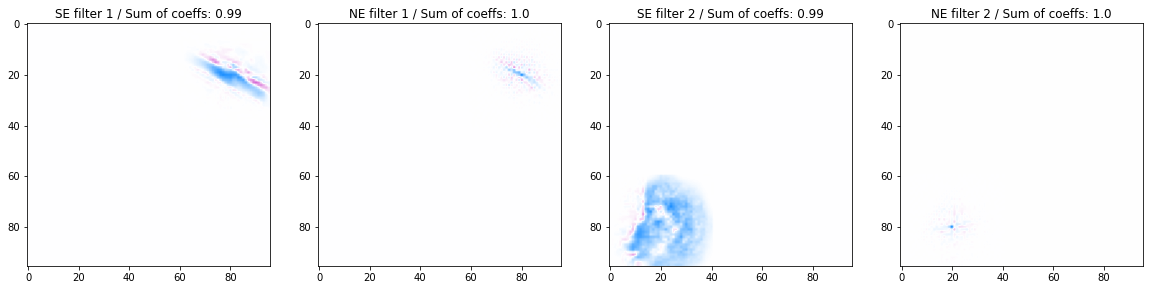

In [9]:
torch.manual_seed(12345678)
img = load_img("./testset_set12/02.png")[:, :, 50:50+96, 50:50+96]

for sigma in [25, 5]:
    print("Sigma:", sigma)
    img_noisy = noise_img(img, sigma/255)
    i, j = 20, 80 # position of the central pixel of the filter

    with torch.no_grad():
        den_O = m_fdncnn_O25(img_noisy)
        den_SE = m_fdncnn_SE25(img_noisy)
        den_NE = m_fdncnn_NE25(img_noisy)

    filter_SE1 = compute_adaptive_filter(m_fdncnn_SE25, img_noisy, i, j)
    filter_NE1 = compute_adaptive_filter(m_fdncnn_NE25, img_noisy, i, j)
    filter_SE2 = compute_adaptive_filter(m_fdncnn_SE25, img_noisy, j, i)
    filter_NE2 = compute_adaptive_filter(m_fdncnn_NE25, img_noisy, j, i)
    
    titles = []
    titles.append("Noisy / PSNR: " +  str(round(psnr(img, img_noisy), 2)) + " dB")
    titles.append("Ordinary / PSNR: " +  str(round(psnr(img, den_O), 2)) + " dB")
    titles.append("Scale-equiv / PSNR: " +  str(round(psnr(img, den_SE), 2)) + " dB")
    titles.append("Norm-equiv / PSNR: " +  str(round(psnr(img, den_NE), 2)) + " dB")
    show_img([img_noisy, den_O, den_SE, den_NE], titles=titles, color=False)
    
    titles = []
    titles.append("SE filter 1 / Sum of coeffs: " +  str(round(float(filter_SE1.sum()), 2)))
    titles.append("NE filter 1 / Sum of coeffs: " +  str(round(float(filter_NE1.sum()), 2)))
    titles.append("SE filter 2 / Sum of coeffs: " +  str(round(float(filter_SE2.sum()), 2)))
    titles.append("NE filter 2 / Sum of coeffs: " +  str(round(float(filter_NE2.sum()), 2)))
    show_img([filter_SE1, filter_NE1, filter_SE2, filter_NE2], titles=titles, color=True)
    